In [9]:
import random
import socket
import struct
import numpy as np
import copy
import hashlib
import intervals
from pprint import pprint
import sys
import math
import matplotlib.pylab as plt
import sys 

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
sys.setrecursionlimit(10**6) 

In [3]:
b=4
lengthOfId=32
lowerleafSetSize = pow(2,b)
higherleafSetSize = pow(2,b)
neighbourhoodSetSize=2*lowerleafSetSize
nodeListDictionary={}
addHops = {}
jumps = 0
numberOfNodes=500
numberOfDataPoints=10000
numberOfSearchQueries=1000000
# allCoordinates={}

In [4]:
def distance(first,second):
    dist = math.sqrt(pow(second[0]-first[0],2)+pow(second[1]-first[1],2))
    return dist

def findLongestMatchingPrefix(first,second):
    matchedString = first[:[x[0]==x[1] for x in zip(first,second)].index(0)]
    return len(matchedString)

# def initializeNode(key,ip,coordinates):
#     tempNode = Node(key,ip,coordinates)
#     nodeListDictionary[key]=tempNode
#     allCoordinates[coordinates]=tempNode
#     tempNode.updateLeafSet()
#     tempNode.updateNeighbourHoodSet()
#     tempNode.initializeRoutingTable()
#     tempNode.updateRoutingTable()
#     return tempNode
    
def checkNumericallyClosest(node1,node2,ref):
    if abs(int(node1,16) - int(ref,16))>abs(int(node2,16)-int(ref,16)):
        return node2
    return node1


def getProximallyClosest(node):
    min_dist = sys.maxsize
    coordList = getAllCoordinates()
    for key,value in coordList.items():
        if key[0]==node.coordinates[0] and key[1]==node.coordinates[1]:
            continue
        if distance(node.coordinates,value.coordinates)<min_dist:
            min_node = value.coordinates
            min_dist = distance(node.coordinates,value.coordinates)
            
    return coordList[min_node]

def getProximallyClosestLookup(coordinates,flag):
    min_dist = sys.maxsize
    coordList = getAllCoordinates()
    for key,value in coordList.items():
        if key[0]==coordinates[0] and key[1]==coordinates[1]:
            continue
        if distance(coordinates,value.coordinates)<min_dist:
            min_node = value.coordinates
            min_dist = distance(coordinates,value.coordinates)
            
    return coordList[min_node]

def initializeFirstTwoNodes(node1,node2):
    #Initialize Neighbourhood Set
    node1.neighbourhoodSet[0] = node2.nodeId
    node2.neighbourhoodSet[0] = node1.nodeId
    
    #Initialize Leaf Set 
    if int(node1.nodeId,16)>int(node2.nodeId,16):
        node1.lowerleafSet[0] = node2.nodeId
        node2.upperleafSet[0] = node1.nodeId
    else:
        node2.lowerleafSet[0] = node1.nodeId
        node1.upperleafSet[0] = node2.nodeId
        
    #Initialize Routing Table 
    longestMatch = findLongestMatchingPrefix(node1.nodeId,node2.nodeId)
    node1.routingTable[longestMatch][int(node2.nodeId[longestMatch],16)]=node2.nodeId
    node2.routingTable[longestMatch][int(node1.nodeId[longestMatch],16)]=node1.nodeId
    
    
def combineAllNodeIds(neighbourhoodSet,leafSet,routingTable):
    allNodeIds = []
    for i in neighbourhoodSet:
        if i=='-1':
            continue
        else:
            allNodeIds.append(i)
    
    for i in leafSet:
        if i=='-1':
            continue
        else:
            allNodeIds.append(i)
        
    for i in routingTable:
        for j in i:
            if j=='-1' or len(j)==1:
                continue
            allNodeIds.append(j)
    
    allNodeIds = list(set(allNodeIds))
    return allNodeIds


def initializeRoutingTable():
    #Initialize Routing Table    
    routingTable=np.empty(lengthOfId*pow(2,b))
    routingTable=[str(-1) for i in routingTable]
    routingTable=np.array(routingTable, dtype = 'object').reshape(lengthOfId,pow(2,b))
    return routingTable

def getAllCoordinates():
    coordinateList={}
    for key,value in nodeListDictionary.items():
        coordinateList[value.coordinates]=value
    
    return coordinateList


def printAllNodesData():
    for key,value in nodeListDictionary.items():
        print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
        print("Node Id : ",key)
        print("Neighbourhood Set: ",value.neighbourhoodSet)
        print("Lower Leaf Set: ",value.lowerleafSet)
        print("Upper Leaf Set: ",value.upperleafSet)
        print("Routing Table: ",value.routingTable)
        print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")


In [5]:
class Node:
    def __init__(self, nodeId, ip,coordinates):
        self.nodeId = nodeId
        self.ipAddress = ip
        self.coordinates = coordinates
        
        #Initialize Neighbourhood Set
        self.neighbourhoodSet=np.empty(neighbourhoodSetSize)
        self.neighbourhoodSet.fill(-1)
        self.neighbourhoodSet=[str(int(i)) for i in self.neighbourhoodSet]
        
        #Initialize Lower Leaf Set       
        self.lowerleafSet=(np.empty(lowerleafSetSize))
        self.lowerleafSet.fill(-1)
        self.lowerleafSet=[str(int(i)) for i in self.lowerleafSet]
        
        #Initialize Upper Leaf Set
        self.upperleafSet=np.empty(higherleafSetSize)
        self.upperleafSet.fill(-1)
        self.upperleafSet=[str(int(i)) for i in self.upperleafSet]
        
        #Initialize Routing Table    
        self.routingTable=np.empty(lengthOfId*pow(2,b))
        self.routingTable=[str(-1) for i in self.routingTable]
        self.routingTable=np.array(self.routingTable, dtype = 'object').reshape(lengthOfId,pow(2,b))
        routingTable = self.routingTable
        (rows,cols)=routingTable.shape
        for index,i in enumerate(routingTable):
            routingTable[index][int(self.nodeId[index],16)]=self.nodeId[index]
            
        #Initialize Data Dictionary
        self.data={}        
        
        #Initialize Status of a Node (1=Present in Network, 0=Deleted From Network)
        self.status = 1
        
        #Append to all node list dictionary
        nodeListDictionary[self.nodeId]=self
           
    #Merge Routing Table for a new Join
    def mergeRoutingTable(self,incomingRoutingTable,incomingId):
        allRoutingTableNodes = np.concatenate((np.array([i for i in incomingRoutingTable.flatten() if i!='-1' and len(i)>1]),[incomingId]))
        ownRoutingTable = self.routingTable
        for i in allRoutingTableNodes:
            if i == self.nodeId:
                continue
            prefixMatch = findLongestMatchingPrefix(i,self.nodeId)
            if ownRoutingTable[prefixMatch][int(i[prefixMatch],16)]=='-1':
                ownRoutingTable[prefixMatch][int(i[prefixMatch],16)] = i
            else:
                coordinates = nodeListDictionary[ownRoutingTable[prefixMatch][int(i[prefixMatch],16)]].coordinates
                coordinates1 = self.coordinates
                coordinates2 = nodeListDictionary[i].coordinates

                if distance(coordinates,coordinates1)>distance(coordinates1,coordinates2):
                    ownRoutingTable[prefixMatch][int(i[prefixMatch],16)] = i
                else:
                    continue
        
        self.routingTable = ownRoutingTable

    def checkProximity(self,totalLeafSet,askNode):
        minNode = askNode
        for i in totalLeafSet:
            if i=='-1':
                continue
            if int(i,16)-int(self.nodeId,16)<int(minNode,16)-int(self.nodeId,16):
                minNode=i
        return minNode
    
    def findNumericallyClosest(self,listOfNodes,key):
        origDistance = abs(int(self.nodeId,16)-int(key,16))
        minNode = self.nodeId
        for i in listOfNodes:
            if i=='-1':
                continue
            if abs(int(i,16)-int(key,16))<origDistance:
                minNode=i
        return minNode 
    

        
    def updateLeafSet(self, closest, lowerleafSet,upperleafSet):
        nodeId = self.nodeId
        if int(nodeId,16)<int(closest,16):
            self.lowerleafSet = self.lowerleafSet
            nodes=[]
            for i in self.upperleafSet:
                if(i!='-1'):
                    nodes.append(i)
            for i in range(len(nodes),len(self.upperleafSet)):
                nodes.append('-1')
            self.upperleafSet = np.concatenate(([closest],nodes[:-1]))
        elif int(nodeId,16)>int(closest,16):
            self.upperleafSet = upperleafSet
            self.lowerleafSet = np.concatenate((self.lowerleafSet[1:],[closest]))
        else:
            print("Node Already Present")        
            
    def getNeighbourhoodSet(self,node):
        nodeListDictionary[node.nodeId].updateNeighbourHoodSet(self.nodeId,self.neighbourhoodSet)
        
        
    def route(self,key,message):
        global jumps
        if message=="join":
            jumps+=1
            if jumps==15:
                return
            self.upperleafSet = sorted(self.upperleafSet,key = lambda s: int(s.split()[0],16))
            self.lowerleafSet = sorted(self.lowerleafSet,key = lambda s: int(s.split()[0],16))
            
            upperLeafSet = self.upperleafSet
            lowerLeafSet = self.lowerleafSet
            lowLeaf = [int(i,16) for i in lowerLeafSet if i!='-1']
            upLeaf = [int(i,16) for i in upperLeafSet if i!='-1']
            if len(upLeaf)==0:
                upLeaf=[sys.maxsize]
            if len(lowLeaf)==0:
                lowLeaf=[-sys.maxsize]
            #print(self.routingTable)
            nodeListDictionary[key].mergeRoutingTable(self.routingTable,self.nodeId)
            numClosestInLeaf = self.findNumericallyClosest(np.concatenate((lowerLeafSet,upperLeafSet)),key)
            if (int(key,16)>=np.min(lowLeaf) and int(key,16)<=np.max(upLeaf)) or (len(upLeaf)+len(lowLeaf))<=lowerleafSetSize:
                #Got in leaf Set
                if (len(upLeaf)+len(lowLeaf))<=lowerleafSetSize:
                    prefixMatchLength = findLongestMatchingPrefix(self.nodeId,key)
                    nodeListDictionary[key].routingTable[prefixMatchLength][int(self.nodeId[prefixMatchLength],16)]=self.nodeId
    
                    if numClosestInLeaf==self.nodeId:
                        nodeListDictionary[key].updateLeafSet(self.nodeId,lowerLeafSet,upperLeafSet)
                        return
                    else:
                        nextNode = numClosestInLeaf
                        nodeListDictionary[nextNode].route(key,"join")
                else:
                    if numClosestInLeaf==self.nodeId:
                        nodeListDictionary[key].updateLeafSet(self.nodeId,lowerLeafSet,upperLeafSet)
                        return
                    else:

                        nextNode = numClosestInLeaf           
                        nodeListDictionary[nextNode].route(key,"join")
            else:
                prefixMatchLength = findLongestMatchingPrefix(self.nodeId,key)
                if self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)]!='-1' and len(self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)])>1:
                    #Got in Routing Table
                    nextNode = self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)]
                    nodeListDictionary[nextNode].route(key,"join")
                else:
                    
                    listOfRoutingTableNodes =np.array([i for i in self.routingTable.flatten() if i!='-1' and len(i)>1])
                    listOfLeafSet = np.array([i for i in np.concatenate((lowerLeafSet,upperLeafSet)) if i!='-1'])
                    listOfNeighbourhoodSet = np.array([i for i in self.neighbourhoodSet if i!='-1'])
                    allNodes = np.unique(np.concatenate((np.concatenate((listOfRoutingTableNodes,listOfLeafSet)),listOfNeighbourhoodSet)))
                    closest = self.findNumericallyClosest(allNodes,key)
                    if closest!=self.nodeId:
                        nodeListDictionary[closest].route(key,"join")
                    else:
                        nodeListDictionary[key].updateLeafSet(self.nodeId,lowerLeafSet,upperLeafSet)
                        
#         elif message=="search":
            
#             jumps+=1
#             if jumps==15:
#                 return self.nodeId
#             self.upperleafSet = sorted(self.upperleafSet,key = lambda s: int(s.split()[0],16))
#             self.lowerleafSet = sorted(self.lowerleafSet,key = lambda s: int(s.split()[0],16))
#             upperLeafSet = self.upperleafSet
#             lowerLeafSet = self.lowerleafSet
#             lowLeaf = [int(i,16) for i in lowerLeafSet if i!='-1']
#             upLeaf = [int(i,16) for i in upperLeafSet if i!='-1']
#             if len(upLeaf)==0:
#                 upLeaf=[sys.maxsize]
#             if len(lowLeaf)==0:
#                 lowLeaf=[-sys.maxsize]
#             numClosestInLeaf = self.findNumericallyClosest(np.concatenate((lowerLeafSet,upperLeafSet)),key)
#             if (int(key,16)>=np.min(lowLeaf) and int(key,16)<=np.max(upLeaf)) or (len(upLeaf)+len(lowLeaf))<=lowerleafSetSize:
#                 #Got in leaf Set
#                 if nodeListDictionary[numClosestInLeaf].status==1:
#                     if (len(upLeaf)+len(lowLeaf))<=lowerleafSetSize:    
#                         if numClosestInLeaf==self.nodeId:
#                             return self.nodeId
#                         else:
#                             nextNode = numClosestInLeaf
#                             return nodeListDictionary[nextNode].route(key,"search")

#                     else:
#                         if numClosestInLeaf==self.nodeId:
#                             return self.nodeId
#                         else:
#                             nextNode = numClosestInLeaf           
#                             return nodeListDictionary[nextNode].route(key,"search")
#                 else:
#                     listOfRoutingTableNodes =np.array([i for i in self.routingTable.flatten() if i!='-1' and len(i)>1])
#                     listOfLeafSet = np.array([i for i in np.concatenate((lowerLeafSet,upperLeafSet)) if i!='-1'])
#                     listOfNeighbourhoodSet = np.array([i for i in self.neighbourhoodSet if i!='-1'])
#                     allNodes = np.unique(np.concatenate((np.concatenate((listOfRoutingTableNodes,listOfLeafSet)),listOfNeighbourhoodSet)))
#                     allNodes = np.delete(allNodes, np.where(allNodes == numClosestInLeaf))
#                     distDict = {i:int(key,16)-int(i,16) for i in allNodes}
#                     distDict = {k: v for k, v in sorted(distDict.items(), key=lambda item: item[1])}
#                     presentDist = abs(int(key,16)-int(self.nodeId,16))
#                     for i in list(distDict.keys()):
#                         if distDict[i]<=presentDist:
#                             if nodeListDictionary[i].status==1:
#                                 if i!=self.nodeId:
#                                     return nodeListDictionary[i].route(key,"search")
#                                 else:
#                                     return i
#                     return self.nodeId
#             else:
#                 prefixMatchLength = findLongestMatchingPrefix(self.nodeId,key)
#                 if self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)]!='-1' and len(self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)])>1:
#                     #Got in Routing Table
#                     nextNode = self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)]
#                     if nodeListDictionary[nextNode].status==1:
#                         return nodeListDictionary[nextNode].route(key,"search")
#                     else:
#                         listOfRoutingTableNodes =np.array([i for i in self.routingTable.flatten() if i!='-1' and len(i)>1])
#                         listOfLeafSet = np.array([i for i in np.concatenate((lowerLeafSet,upperLeafSet)) if i!='-1'])
#                         listOfNeighbourhoodSet = np.array([i for i in self.neighbourhoodSet if i!='-1'])
#                         allNodes = np.unique(np.concatenate((np.concatenate((listOfRoutingTableNodes,listOfLeafSet)),listOfNeighbourhoodSet)))
#                         allNodes = np.delete(allNodes, np.where(allNodes == nextNode))
#                         distDict = {i:int(key,16)-int(i,16) for i in allNodes}
#                         distDict = {k: v for k, v in sorted(distDict.items(), key=lambda item: item[1])}
#                         presentDist = abs(int(key,16)-int(self.nodeId,16))
#                         for i in list(distDict.keys()):
#                             if distDict[i]<=presentDist:
#                                 if nodeListDictionary[i].status==1:
#                                     if i!=self.nodeId:
#                                         return nodeListDictionary[i].route(key,"search")
#                                     else:
#                                         return i
#                         return self.nodeId 
#                 else:
#                     listOfRoutingTableNodes =np.array([i for i in self.routingTable.flatten() if i!='-1' and len(i)>1])
#                     listOfLeafSet = np.array([i for i in np.concatenate((lowerLeafSet,upperLeafSet)) if i!='-1'])
#                     listOfNeighbourhoodSet = np.array([i for i in self.neighbourhoodSet if i!='-1'])
#                     allNodes = np.unique(np.concatenate((np.concatenate((listOfRoutingTableNodes,listOfLeafSet)),listOfNeighbourhoodSet)))
#                     closest = self.findNumericallyClosest(allNodes,key)
#                     if nodeListDictionary[closest].status==1:
#                         if closest!=self.nodeId:
#                             return nodeListDictionary[closest].route(key,"search")
#                         else:
#                             return self.nodeId
                        
#                     else:
#                         listOfLeafSet = np.array([i for i in np.concatenate((self.lowerleafSet,self.upperleafSet)) if i!='-1'])
#                         allNodes = np.delete(allNodes, np.where(allNodes == closest))
#                         distDict = {i:abs(int(key,16)-int(i,16)) for i in allNodes}
#                         distDict = {k: v for k, v in sorted(distDict.items(), key=lambda item: item[1])}
#                         presentDist = abs(int(key,16)-int(self.nodeId,16))
#                         for i in list(distDict.keys()):
#                             if distDict[i]<=presentDist:
#                                 if nodeListDictionary[i].status==1:
#                                     if i!=self.nodeId:
#                                         return nodeListDictionary[i].route(key,"search")
#                                     else:
#                                         return i
#                         return self.nodeId
        
    def routeData(self,key):
        global jumps
        jumps+=1
        leafset2 = [i for i in self.lowerleafSet if i!='-1']
        leafset1=[i for i in self.upperleafSet if i!='-1']
        leafset = leafset2 + leafset1
        leafsetint = [int(i,16) for i in leafset]
        
        if len(leafsetint)>0 and int(key,16)>=np.min(leafsetint) and int(key,16)<=np.max(leafsetint):
            orig = abs(int(key,16)-int(self.nodeId,16))
            node = self.nodeId
            for i in leafset:
                if abs(int(i,16) - int(key,16))<orig:
                    orig = abs(int(i,16) - int(key,16))
                    node = i
            if node==self.nodeId:
                return self.nodeId
            else:
                if nodeListDictionary[node].status==1:
                    return nodeListDictionary[node].routeData(key)
                else:
                    allNodes=leafset
                    allNodes+=[i for i in self.neighbourhoodSet if i!='-1']
                    allNodes+=[y for x in self.routingTable for y in x]
                    if allNodes:
                        common_prefix = findLongestMatchingPrefix(self.nodeId,key)
                        possible = []
                        for i in allNodes:
                            if i=='-1' or len(i)<3:
                                continue
                            if common_prefix<findLongestMatchingPrefix(i,key):
                                possible.append(i)
                        if len(possible)==0:
                            return self.nodeId
                        closest = abs(int(possible[0],16) - int(key,16))
                        node =possible[0]
                        all_possible = {}
                        for i in possible:
                            if abs(int(i,16)-int(key,16)) < closest:
                                closest = abs(int(i,16)-int(key,16))
                                node = i
                                all_possible[node]=closest
                        if node == self.nodeId:
                            return self.nodeId
                        if nodeListDictionary[node].status==1:
                            return nodeListDictionary[node].routeData(key)
                        else:
                            allSorted = {k: v for k, v in sorted(all_possible.items(), key=lambda item: item[1])}
                            for key1,value in allSorted.items():
                                if nodeListDictionary[key1].status==1:
                                    return nodeListDictionary[key1].routeData(key)
                            return self.nodeId
        else:
            common_prefix = findLongestMatchingPrefix(self.nodeId,key)
            nextNode = self.routingTable[common_prefix][int(key[common_prefix],16)]
            if abs(int(self.nodeId,16)-int(key,16))<=abs(int(nextNode,16)-int(key,16)):
                return self.nodeId
            if nextNode !='-1' and len(nextNode)>1:
                if nodeListDictionary[nextNode].status==1:
                    return nodeListDictionary[nextNode].routeData(key)
                else:
                    allNodes=leafset
                    allNodes+=[i for i in self.neighbourhoodSet if i!='-1']
                    allNodes+=[y for x in self.routingTable for y in x]
                    if allNodes:
                        common_prefix = findLongestMatchingPrefix(self.nodeId,key)
                        possible = []
                        for i in allNodes:
                            if i=='-1' or len(i)<3:
                                continue
                            if common_prefix<findLongestMatchingPrefix(i,key):
                                possible.append(i)
                        if len(possible)==0:
                            return self.nodeId
                        closest = abs(int(possible[0],16) - int(key,16))
                        node =possible[0]
                        all_possible = {}
                        for i in possible:
                            if abs(int(i,16)-int(key,16)) < closest:
                                closest = abs(int(i,16)-int(key,16))
                                node = i
                                all_possible[node]=closest
                        if node == self.nodeId:
                            return self.nodeId
                        if nodeListDictionary[node].status==1:
                            return nodeListDictionary[node].routeData(key)
                        else:
                            allSorted = {k: v for k, v in sorted(all_possible.items(), key=lambda item: item[1])}
                            for key1,value in allSorted.items():
                                if nodeListDictionary[key1].status==1:
                                    return nodeListDictionary[key1].routeData(key)
                            return self.nodeId
            else:
                allNodes=leafset
                allNodes+=[i for i in self.neighbourhoodSet if i!='-1']
                allNodes+=[y for x in self.routingTable for y in x]
                if allNodes:
                    common_prefix = findLongestMatchingPrefix(self.nodeId,key)
                    possible = []
                    for i in allNodes:
                        if i=='-1' or len(i)<3:
                            continue
                        if common_prefix<findLongestMatchingPrefix(i,key):
                            possible.append(i)
                    if len(possible)==0:
                        return self.nodeId
                    closest = abs(int(possible[0],16) - int(key,16))
                    node =possible[0]
                    for i in possible:
                        if abs(int(i,16)-int(key,16)) < closest:
                            closest = abs(int(i,16)-int(key,16))
                            node = i
                    if node == self.nodeId:
                        return self.nodeId
                    if nodeListDictionary[node].status==1:
                        return nodeListDictionary[node].routeData(key)
                    else:
                        return self.nodeId
                
                
    def updateLeafSetOfOthers(self,nodeId):
        if int(self.nodeId,16)>int(nodeId,16):
            temp = np.concatenate((self.lowerleafSet,[nodeId]))
            check = []
            for i in temp:
                if i!='-1':
                    check.append(i)
            
            check = sorted(check,key = lambda s: int(s.split()[0],16))
            for i in range(len(check),len(self.lowerleafSet)):
                check.insert(0,'-1')
            if len(check)>lowerleafSetSize:
                self.lowerleafSet = check[1:]
            else:
                self.lowerleafSet = check
        else:
            temp = np.concatenate((self.upperleafSet,[nodeId]))

            check = []
            for i in temp:
                if i!='-1':
                    check.append(i)
            
            check = sorted(check,key = lambda s: int(s.split()[0],16))

            for i in range(len(check), len(self.upperleafSet)):
                check.append('-1')

            if len(check)>higherleafSetSize:
                self.upperleafSet = check[:-1]
            else:
                self.upperleafSet = check
            
    def updateNeighbourHoodSet(self,closestNodeId,neighbourhoodSet):
        myNeighbourhood = []
        distanceNodeDict = {}
        neighbourhoodSet = np.concatenate((neighbourhoodSet,[closestNodeId]))
        for i in neighbourhoodSet:
            if i=='-1':
                continue
            elif distance(self.coordinates,nodeListDictionary[i].coordinates)==0:
                continue
            else:
                distanceNodeDict[distance(self.coordinates,nodeListDictionary[i].coordinates)] = i
        sortedIds = []
        for j in sorted(list(distanceNodeDict.keys())):
            sortedIds.append(distanceNodeDict[j])
        if len(sortedIds)<=neighbourhoodSetSize:
            myNeighbourhood = sortedIds
        else:
            myNeighbourhood = (sortedIds[:-1])
        for i,j in enumerate(myNeighbourhood):
            self.neighbourhoodSet[i] = j
        
    def updateOthers(self):
        listOfRoutingTableNodes =np.array([i for i in self.routingTable.flatten() if i!='-1' and len(i)>2])
        listOfLeafSet = np.array([i for i in np.concatenate((self.lowerleafSet,self.upperleafSet)) if i!='-1'])
        listOfNeighbourhoodSet = np.array([i for i in self.neighbourhoodSet if i!='-1'])
        allNodes = np.unique(np.concatenate((np.concatenate((listOfRoutingTableNodes,listOfLeafSet)),listOfNeighbourhoodSet)))
        ownRoutingTable = self.routingTable
        for i in allNodes:
            if i==self.nodeId:
                continue
            toUpdate = nodeListDictionary[i]
            toUpdate.mergeRoutingTable(self.routingTable,self.nodeId)
            toUpdate.updateNeighbourHoodSet(self.nodeId,self.neighbourhoodSet)
            toUpdate.updateLeafSetOfOthers(self.nodeId)
            
        
    def join(self):
        newNode = self.nodeId
        askNode = getProximallyClosest(self)
        if askNode.status==1:
            askNode.getNeighbourhoodSet(self)
            askNode.route(newNode,"join")
            self.updateOthers()
        else:
            print("Can't Join. Neighbourhood exited the pastry network")
#         pass       
    
    def remove(self):
        self.status = 0
            
    def lookup(self,key):
        askNode = self
        
        requiredNode = askNode.routeData(key)

#         print("Data Found at:",requiredNode)
        return requiredNode
    
    def addData(self,key,value):
        requiredNode = self.routeData(key)
        
        nodeListDictionary[requiredNode].data[key]=value
        

In [6]:
totalData={}
totalDataAfterDeletion = {}
listOfNodes = [100,500,1000]
for numberOfNodes in listOfNodes:
    print("xxxxxxxxxxxxxNumber of Nodes = ",numberOfNodes,"xxxxxxxxxxxxxxxxxxxx")
    coordinateList = [(random.randrange(0, 50), random.randrange(0, 20)) for i in range(numberOfNodes)]
    all_ip_address= [socket.inet_ntoa(struct.pack('>I', random.randint(0x3cffffff, 0xffffffff))) for i in range(numberOfNodes)]
    allNodeIds = [hashlib.md5(all_ip_address[i].encode()).hexdigest() for i in range(numberOfNodes)]
    global jumps
    nodeListDictionary={}
    # coordinateList = [(32, 3), (11, 15), (19, 8), (0, 5), (12, 1), (20, 13)]
    # nodeListDictionary={}
    # allNodeIds = ['00102000', '22100022', '11111011', '31100311', '31230210', '23012002']
    #First Node
    firstNodeIP = str(all_ip_address[0])
    firstNodeCoordinates = coordinateList[0]
    firstNodeKey = str(allNodeIds[0])
    firstNode=Node(firstNodeKey,firstNodeIP,firstNodeCoordinates)

    #Second Node
    secondNodeIP = str(all_ip_address[1])
    secondNodeCoordinates = coordinateList[1]
    secondNodeKey = str(allNodeIds[1])
    secondNode=Node(secondNodeKey,secondNodeIP,secondNodeCoordinates)
    initializeFirstTwoNodes(firstNode,secondNode)
    # printAllNodesData()
    print("---------------Creating Nodes--------------------")
    for i in range(2,numberOfNodes):
        tempNodeIP = (all_ip_address[i])
        tempNodeCoordinates = coordinateList[i]
        tempNodeKey = allNodeIds[i]
#         print("Node Added: ",tempNodeKey)
        tempNode = Node(tempNodeKey,tempNodeIP,tempNodeCoordinates)
        jumps=0
        tempNode.join()
    print("--------------Adding Data-----------------------")
    dataStoredTemp=random.sample(range(10, 1000000), numberOfDataPoints)
    for index,i in enumerate(dataStoredTemp):
        data = str(i)
        keyData = hashlib.md5(data.encode()).hexdigest()
        coord = (random.randrange(0, 50), random.randrange(0, 20))
#         print("Data Added : ",keyData)
        addHops[data]=0
        jumps=0
        getProximallyClosestLookup(coord,1).addData(keyData,data)
    #     print("-----------------------------------------------")

    print("-------------Querying Data--------------------")
    dataToSearch = random.sample(range(1, 1060000), numberOfSearchQueries)
    coordinatesOfSearch = [(random.randrange(0, 50), random.randrange(0, 20)) for i in range(numberOfSearchQueries)]
    hopData = {}
    flag = 0
    
    for index,i in enumerate(dataToSearch):
    #         print("Required Data ",i)
        if flag%1000==0:
            print("Data Searched: ",flag)
        hashValueOfData = hashlib.md5(str(i).encode()).hexdigest()
        coordinates = coordinatesOfSearch[index]
        addHops[hashValueOfData]=0
        jumps = 0
        result = getProximallyClosestLookup(coordinates,1).lookup(hashValueOfData)
        addHops[hashValueOfData]=jumps
        hopData[hashValueOfData]=addHops[hashValueOfData]
        flag+=1
        
    totalData[numberOfNodes]=[]
    totalData[numberOfNodes].append(hopData)
    if numberOfNodes==100:
        print("-----------Deleting 50% nodes------------------")
        allKeys = list(nodeListDictionary.keys())

        toBeDeleted = random.sample(allKeys,int(numberOfNodes/2))
        for i in toBeDeleted:
            nodeListDictionary[i].remove()

        hopData = {}
        flag = 0
        print("---------------Searching Again-------------")
        for index,i in enumerate(dataToSearch):
        #         print("Required Data ",i)
            if flag%1000==0:
                print("Data Searched: ",flag)
            hashValueOfData = hashlib.md5(str(i).encode()).hexdigest()
            coordinates = coordinatesOfSearch[index]
            addHops[hashValueOfData]=0
            jumps = 0
            result = getProximallyClosestLookup(coordinates,1).lookup(hashValueOfData)
            addHops[hashValueOfData]=jumps
            hopData[hashValueOfData]=addHops[hashValueOfData]
            flag+=1
        totalDataAfterDeletion[numberOfNodes] = []
        totalDataAfterDeletion[numberOfNodes].append(hopData)

xxxxxxxxxxxxxNumber of Nodes =  100 xxxxxxxxxxxxxxxxxxxx
---------------Creating Nodes--------------------
--------------Adding Data-----------------------
-------------Querying Data--------------------
Data Searched:  0
Data Searched:  1000
Data Searched:  2000
Data Searched:  3000
Data Searched:  4000
Data Searched:  5000
Data Searched:  6000
Data Searched:  7000
Data Searched:  8000
Data Searched:  9000
Data Searched:  10000
Data Searched:  11000
Data Searched:  12000
Data Searched:  13000
Data Searched:  14000
Data Searched:  15000
Data Searched:  16000
Data Searched:  17000
Data Searched:  18000
Data Searched:  19000
Data Searched:  20000
Data Searched:  21000
Data Searched:  22000
Data Searched:  23000
Data Searched:  24000
Data Searched:  25000
Data Searched:  26000
Data Searched:  27000
Data Searched:  28000
Data Searched:  29000
Data Searched:  30000
Data Searched:  31000
Data Searched:  32000
Data Searched:  33000
Data Searched:  34000
Data Searched:  35000
Data Searched:  36

Data Searched:  353000
Data Searched:  354000
Data Searched:  355000
Data Searched:  356000
Data Searched:  357000
Data Searched:  358000
Data Searched:  359000
Data Searched:  360000
Data Searched:  361000
Data Searched:  362000
Data Searched:  363000
Data Searched:  364000
Data Searched:  365000
Data Searched:  366000
Data Searched:  367000
Data Searched:  368000
Data Searched:  369000
Data Searched:  370000
Data Searched:  371000
Data Searched:  372000
Data Searched:  373000
Data Searched:  374000
Data Searched:  375000
Data Searched:  376000
Data Searched:  377000
Data Searched:  378000
Data Searched:  379000
Data Searched:  380000
Data Searched:  381000
Data Searched:  382000
Data Searched:  383000
Data Searched:  384000
Data Searched:  385000
Data Searched:  386000
Data Searched:  387000
Data Searched:  388000
Data Searched:  389000
Data Searched:  390000
Data Searched:  391000
Data Searched:  392000
Data Searched:  393000
Data Searched:  394000
Data Searched:  395000
Data Search

Data Searched:  710000
Data Searched:  711000
Data Searched:  712000
Data Searched:  713000
Data Searched:  714000
Data Searched:  715000
Data Searched:  716000
Data Searched:  717000
Data Searched:  718000
Data Searched:  719000
Data Searched:  720000
Data Searched:  721000
Data Searched:  722000
Data Searched:  723000
Data Searched:  724000
Data Searched:  725000
Data Searched:  726000
Data Searched:  727000
Data Searched:  728000
Data Searched:  729000
Data Searched:  730000
Data Searched:  731000
Data Searched:  732000
Data Searched:  733000
Data Searched:  734000
Data Searched:  735000
Data Searched:  736000
Data Searched:  737000
Data Searched:  738000
Data Searched:  739000
Data Searched:  740000
Data Searched:  741000
Data Searched:  742000
Data Searched:  743000
Data Searched:  744000
Data Searched:  745000
Data Searched:  746000
Data Searched:  747000
Data Searched:  748000
Data Searched:  749000
Data Searched:  750000
Data Searched:  751000
Data Searched:  752000
Data Search

Data Searched:  66000
Data Searched:  67000
Data Searched:  68000
Data Searched:  69000
Data Searched:  70000
Data Searched:  71000
Data Searched:  72000
Data Searched:  73000
Data Searched:  74000
Data Searched:  75000
Data Searched:  76000
Data Searched:  77000
Data Searched:  78000
Data Searched:  79000
Data Searched:  80000
Data Searched:  81000
Data Searched:  82000
Data Searched:  83000
Data Searched:  84000
Data Searched:  85000
Data Searched:  86000
Data Searched:  87000
Data Searched:  88000
Data Searched:  89000
Data Searched:  90000
Data Searched:  91000
Data Searched:  92000
Data Searched:  93000
Data Searched:  94000
Data Searched:  95000
Data Searched:  96000
Data Searched:  97000
Data Searched:  98000
Data Searched:  99000
Data Searched:  100000
Data Searched:  101000
Data Searched:  102000
Data Searched:  103000
Data Searched:  104000
Data Searched:  105000
Data Searched:  106000
Data Searched:  107000
Data Searched:  108000
Data Searched:  109000
Data Searched:  110000

Data Searched:  424000
Data Searched:  425000
Data Searched:  426000
Data Searched:  427000
Data Searched:  428000
Data Searched:  429000
Data Searched:  430000
Data Searched:  431000
Data Searched:  432000
Data Searched:  433000
Data Searched:  434000
Data Searched:  435000
Data Searched:  436000
Data Searched:  437000
Data Searched:  438000
Data Searched:  439000
Data Searched:  440000
Data Searched:  441000
Data Searched:  442000
Data Searched:  443000
Data Searched:  444000
Data Searched:  445000
Data Searched:  446000
Data Searched:  447000
Data Searched:  448000
Data Searched:  449000
Data Searched:  450000
Data Searched:  451000
Data Searched:  452000
Data Searched:  453000
Data Searched:  454000
Data Searched:  455000
Data Searched:  456000
Data Searched:  457000
Data Searched:  458000
Data Searched:  459000
Data Searched:  460000
Data Searched:  461000
Data Searched:  462000
Data Searched:  463000
Data Searched:  464000
Data Searched:  465000
Data Searched:  466000
Data Search

Data Searched:  781000
Data Searched:  782000
Data Searched:  783000
Data Searched:  784000
Data Searched:  785000
Data Searched:  786000
Data Searched:  787000
Data Searched:  788000
Data Searched:  789000
Data Searched:  790000
Data Searched:  791000
Data Searched:  792000
Data Searched:  793000
Data Searched:  794000
Data Searched:  795000
Data Searched:  796000
Data Searched:  797000
Data Searched:  798000
Data Searched:  799000
Data Searched:  800000
Data Searched:  801000
Data Searched:  802000
Data Searched:  803000
Data Searched:  804000
Data Searched:  805000
Data Searched:  806000
Data Searched:  807000
Data Searched:  808000
Data Searched:  809000
Data Searched:  810000
Data Searched:  811000
Data Searched:  812000
Data Searched:  813000
Data Searched:  814000
Data Searched:  815000
Data Searched:  816000
Data Searched:  817000
Data Searched:  818000
Data Searched:  819000
Data Searched:  820000
Data Searched:  821000
Data Searched:  822000
Data Searched:  823000
Data Search

Data Searched:  134000
Data Searched:  135000
Data Searched:  136000
Data Searched:  137000
Data Searched:  138000
Data Searched:  139000
Data Searched:  140000
Data Searched:  141000
Data Searched:  142000
Data Searched:  143000
Data Searched:  144000
Data Searched:  145000
Data Searched:  146000
Data Searched:  147000
Data Searched:  148000
Data Searched:  149000
Data Searched:  150000
Data Searched:  151000
Data Searched:  152000
Data Searched:  153000
Data Searched:  154000
Data Searched:  155000
Data Searched:  156000
Data Searched:  157000
Data Searched:  158000
Data Searched:  159000
Data Searched:  160000
Data Searched:  161000
Data Searched:  162000
Data Searched:  163000
Data Searched:  164000
Data Searched:  165000
Data Searched:  166000
Data Searched:  167000
Data Searched:  168000
Data Searched:  169000
Data Searched:  170000
Data Searched:  171000
Data Searched:  172000
Data Searched:  173000
Data Searched:  174000
Data Searched:  175000
Data Searched:  176000
Data Search

Data Searched:  491000
Data Searched:  492000
Data Searched:  493000
Data Searched:  494000
Data Searched:  495000
Data Searched:  496000
Data Searched:  497000
Data Searched:  498000
Data Searched:  499000
Data Searched:  500000
Data Searched:  501000
Data Searched:  502000
Data Searched:  503000
Data Searched:  504000
Data Searched:  505000
Data Searched:  506000
Data Searched:  507000
Data Searched:  508000
Data Searched:  509000
Data Searched:  510000
Data Searched:  511000
Data Searched:  512000
Data Searched:  513000
Data Searched:  514000
Data Searched:  515000
Data Searched:  516000
Data Searched:  517000
Data Searched:  518000
Data Searched:  519000
Data Searched:  520000
Data Searched:  521000
Data Searched:  522000
Data Searched:  523000
Data Searched:  524000
Data Searched:  525000
Data Searched:  526000
Data Searched:  527000
Data Searched:  528000
Data Searched:  529000
Data Searched:  530000
Data Searched:  531000
Data Searched:  532000
Data Searched:  533000
Data Search

Data Searched:  848000
Data Searched:  849000
Data Searched:  850000
Data Searched:  851000
Data Searched:  852000
Data Searched:  853000
Data Searched:  854000
Data Searched:  855000
Data Searched:  856000
Data Searched:  857000
Data Searched:  858000
Data Searched:  859000
Data Searched:  860000
Data Searched:  861000
Data Searched:  862000
Data Searched:  863000
Data Searched:  864000
Data Searched:  865000
Data Searched:  866000
Data Searched:  867000
Data Searched:  868000
Data Searched:  869000
Data Searched:  870000
Data Searched:  871000
Data Searched:  872000
Data Searched:  873000
Data Searched:  874000
Data Searched:  875000
Data Searched:  876000
Data Searched:  877000
Data Searched:  878000
Data Searched:  879000
Data Searched:  880000
Data Searched:  881000
Data Searched:  882000
Data Searched:  883000
Data Searched:  884000
Data Searched:  885000
Data Searched:  886000
Data Searched:  887000
Data Searched:  888000
Data Searched:  889000
Data Searched:  890000
Data Search

Data Searched:  201000
Data Searched:  202000
Data Searched:  203000
Data Searched:  204000
Data Searched:  205000
Data Searched:  206000
Data Searched:  207000
Data Searched:  208000
Data Searched:  209000
Data Searched:  210000
Data Searched:  211000
Data Searched:  212000
Data Searched:  213000
Data Searched:  214000
Data Searched:  215000
Data Searched:  216000
Data Searched:  217000
Data Searched:  218000
Data Searched:  219000
Data Searched:  220000
Data Searched:  221000
Data Searched:  222000
Data Searched:  223000
Data Searched:  224000
Data Searched:  225000
Data Searched:  226000
Data Searched:  227000
Data Searched:  228000
Data Searched:  229000
Data Searched:  230000
Data Searched:  231000
Data Searched:  232000
Data Searched:  233000
Data Searched:  234000
Data Searched:  235000
Data Searched:  236000
Data Searched:  237000
Data Searched:  238000
Data Searched:  239000
Data Searched:  240000
Data Searched:  241000
Data Searched:  242000
Data Searched:  243000
Data Search

Data Searched:  558000
Data Searched:  559000
Data Searched:  560000
Data Searched:  561000
Data Searched:  562000
Data Searched:  563000
Data Searched:  564000
Data Searched:  565000
Data Searched:  566000
Data Searched:  567000
Data Searched:  568000
Data Searched:  569000
Data Searched:  570000
Data Searched:  571000
Data Searched:  572000
Data Searched:  573000
Data Searched:  574000
Data Searched:  575000
Data Searched:  576000
Data Searched:  577000
Data Searched:  578000
Data Searched:  579000
Data Searched:  580000
Data Searched:  581000
Data Searched:  582000
Data Searched:  583000
Data Searched:  584000
Data Searched:  585000
Data Searched:  586000
Data Searched:  587000
Data Searched:  588000
Data Searched:  589000
Data Searched:  590000
Data Searched:  591000
Data Searched:  592000
Data Searched:  593000
Data Searched:  594000
Data Searched:  595000
Data Searched:  596000
Data Searched:  597000
Data Searched:  598000
Data Searched:  599000
Data Searched:  600000
Data Search

Data Searched:  915000
Data Searched:  916000
Data Searched:  917000
Data Searched:  918000
Data Searched:  919000
Data Searched:  920000
Data Searched:  921000
Data Searched:  922000
Data Searched:  923000
Data Searched:  924000
Data Searched:  925000
Data Searched:  926000
Data Searched:  927000
Data Searched:  928000
Data Searched:  929000
Data Searched:  930000
Data Searched:  931000
Data Searched:  932000
Data Searched:  933000
Data Searched:  934000
Data Searched:  935000
Data Searched:  936000
Data Searched:  937000
Data Searched:  938000
Data Searched:  939000
Data Searched:  940000
Data Searched:  941000
Data Searched:  942000
Data Searched:  943000
Data Searched:  944000
Data Searched:  945000
Data Searched:  946000
Data Searched:  947000
Data Searched:  948000
Data Searched:  949000
Data Searched:  950000
Data Searched:  951000
Data Searched:  952000
Data Searched:  953000
Data Searched:  954000
Data Searched:  955000
Data Searched:  956000
Data Searched:  957000
Data Search

------------plots before deletion--------------
--------------plots after deletion---------------


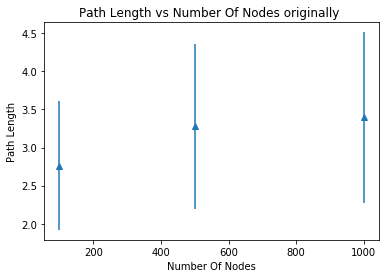

<Figure size 432x288 with 0 Axes>

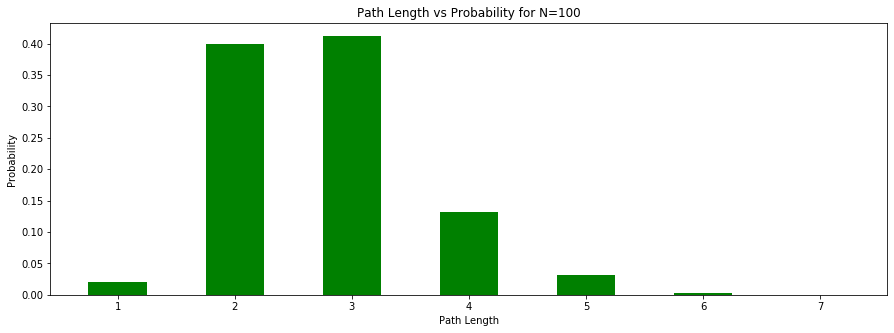

<Figure size 432x288 with 0 Axes>

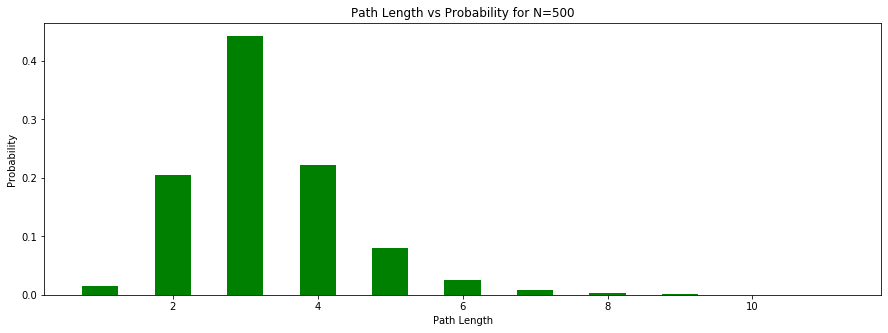

<Figure size 432x288 with 0 Axes>

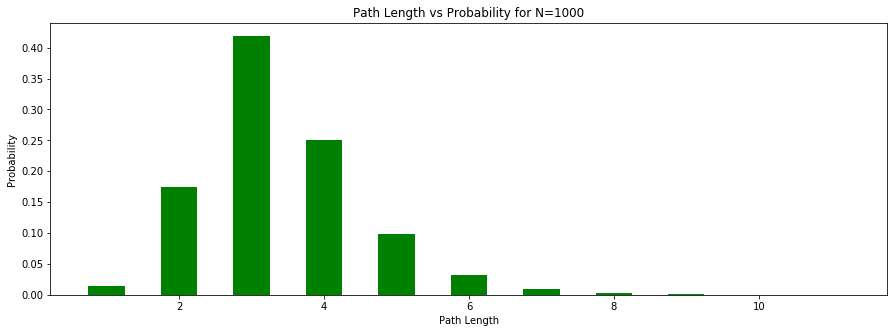

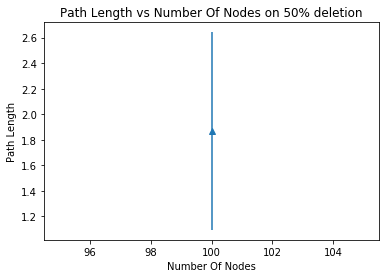

<Figure size 432x288 with 0 Axes>

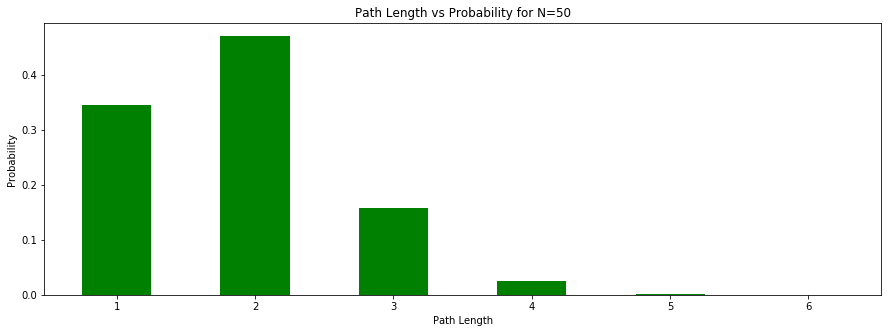

In [11]:
#----------------PLOTS-------------------
print("------------plots before deletion--------------")
mapAverageHopsMean = {}
mapAverageHopsStd = {}
mapAverageHops = {}
for key,value in totalData.items():
    
    mapAverageHops[key]=0
    count=0
    for i,j in value[0].items():
        count+=j
    listofvalues = [j for i,j in value[0].items()]
    mapAverageHopsMean[key]=np.mean(listofvalues)
    mapAverageHopsStd[key]=np.std(listofvalues)
    
lists = sorted(mapAverageHopsMean.items())
lists1 = sorted(mapAverageHopsStd.items())    
x, y = zip(*lists)
a,b = zip(*lists1)
fig1 = plt.figure()
plt.errorbar(x, y, b, linestyle='None', marker='^')
plt.xlabel("Number Of Nodes")
plt.ylabel("Path Length")
# plt.show()
plt.title("Path Length vs Number Of Nodes originally ")
plt.savefig("nodesPathLength.eps",format="eps")

numnodes = [100,500,1000]
for i in numnodes:
    fig1 = plt.figure()
    test = totalData[i][0]
    new = {}
    for k,v in test.items():
        if v not in new.keys():
            new[v]=[]
        new[v].append(k)

    new_data = {k:len(v)/numberOfSearchQueries for k,v in new.items()}

    plt.figure(figsize=(15,5))
    plt.bar(new_data.keys(), new_data.values(), width=.5, color='g')
    plt.xlabel("Path Length")
    plt.ylabel("Probability")
    plt.title("Path Length vs Probability for N="+str(i))
    plt.savefig("pathLengthProbability_"+str(i)+".eps",format="eps")
    


print("--------------plots after deletion---------------")
mapAverageHopsMean = {}
mapAverageHopsStd = {}
mapAverageHops = {}
for key,value in totalDataAfterDeletion.items():
    
    mapAverageHops[key]=0
    count=0
    for i,j in value[0].items():
        count+=j
    listofvalues = [j for i,j in value[0].items()]
    mapAverageHopsMean[key]=np.mean(listofvalues)
    mapAverageHopsStd[key]=np.std(listofvalues)
    
lists = sorted(mapAverageHopsMean.items())
lists1 = sorted(mapAverageHopsStd.items())    
x, y = zip(*lists)
a,b = zip(*lists1)
fig1 = plt.figure()
plt.errorbar(x, y, b, linestyle='None', marker='^')
plt.xlabel("Number Of Nodes")
plt.ylabel("Path Length")
# plt.show()
plt.title("Path Length vs Number Of Nodes on 50% deletion")
plt.savefig("nodesPathLengthDel.eps",format="eps")

numnodes = [100]
for i in numnodes:
    fig1 = plt.figure()
    test = totalDataAfterDeletion[i][0]
    new = {}
    for k,v in test.items():
        if v not in new.keys():
            new[v]=[]
        new[v].append(k)
    
    new_data = {k:len(v)/numberOfSearchQueries for k,v in new.items()}
    import matplotlib.pylab as plt
    plt.figure(figsize=(15,5))
    plt.bar(new_data.keys(), new_data.values(), width=.5, color='g')
    plt.xlabel("Path Length")
    plt.ylabel("Probability")
    plt.title("Path Length vs Probability for N="+str(i//2))
    plt.savefig("pathLengthProbabilityDel_"+str(i//2)+".eps",format="eps")

In [ ]:
allNodeIds = ['51a7af9b1afef4a54ded8776c802c8ab','91c714102717cdaba8b55136767eaf08','21d9e777db06b4d9e8dece3fea8ce788','b6ab6371b0f40505aa98e1c1b80b3b1e','f466e859bb14dde8697665f3feac1f73','1651a8a06aab6e46e09fb1159da8911b','2c584e55e46a46087b8e26f3d690fd2c','103b1bab96ec034ac09cb8f25f6b03b0','5e85d51c7d9315177e19794fbb570b5b','a3cf7490195100b6487d63f1ab65597f','d6844d3c488edf064c11a3b434e3cdf2',
         '967c9f5abdc999f55db798a91bc8935e']

In [ ]:
coordinateList = [(-10.213397977299588, -5.699599219674067),(8.959540220566693, 0.5269234626389371), (1.160237980268704, -0.6168546084974285),
              (6.774693512726898, 1.784010758301928),(7.56973837196581, 4.99330303433158),(-4.570121713413258, -2.3942757421310334), (-8.899631413386413, 2.816521308323107),
              (0.5591368737821016, 1.2544565740740568),(-2.6281881528389652, -11.596102244386422),(-9.76823499344688, 5.875426207262635), (3.3190660149795246, 5.092174345842763),
              (10.643835089939573, 4.0278812959712145)]

In [ ]:
all_ip_address= [socket.inet_ntoa(struct.pack('>I', random.randint(0x3cffffff, 0xffffffff))) for i in range(12)]
firstNodeIP = str(all_ip_address[0])
firstNodeCoordinates = coordinateList[0]
firstNodeKey = str(allNodeIds[0])
firstNode=Node(firstNodeKey,firstNodeIP,firstNodeCoordinates)

#Second Node
secondNodeIP = str(all_ip_address[1])
secondNodeCoordinates = coordinateList[1]
secondNodeKey = str(allNodeIds[1])
secondNode=Node(secondNodeKey,secondNodeIP,secondNodeCoordinates)
initializeFirstTwoNodes(firstNode,secondNode)

In [ ]:
numberOfNodes=12
for i in range(2,numberOfNodes):
    tempNodeIP = (all_ip_address[i])
    tempNodeCoordinates = coordinateList[i]
    tempNodeKey = allNodeIds[i]
    print("Node Added: ",tempNodeKey)
    tempNode = Node(tempNodeKey,tempNodeIP,tempNodeCoordinates)
    jumps=0
    tempNode.join()

In [ ]:
vars(nodeListDictionary['51a7af9b1afef4a54ded8776c802c8ab'])

In [ ]:
 jumps+=1
            if jumps==15:
                return self.nodeId
            self.upperleafSet = sorted(self.upperleafSet,key = lambda s: int(s.split()[0],16))
            self.lowerleafSet = sorted(self.lowerleafSet,key = lambda s: int(s.split()[0],16))
            upperLeafSet = self.upperleafSet
            lowerLeafSet = self.lowerleafSet
            lowLeaf = [int(i,16) for i in lowerLeafSet if i!='-1']
            upLeaf = [int(i,16) for i in upperLeafSet if i!='-1']
            if len(upLeaf)==0:
                upLeaf=[sys.maxsize]
            if len(lowLeaf)==0:
                lowLeaf=[-sys.maxsize]
            numClosestInLeaf = self.findNumericallyClosest(np.concatenate((lowerLeafSet,upperLeafSet)),key)
            if (int(key,16)>=np.min(lowLeaf) and int(key,16)<=np.max(upLeaf)) and (len(upLeaf)+len(lowLeaf))<=lowerleafSetSize:
                #Got in leaf Set
                if nodeListDictionary[numClosestInLeaf].status==1:
                    if (len(upLeaf)+len(lowLeaf))<=lowerleafSetSize:    
                        if numClosestInLeaf==self.nodeId:
                            return self.nodeId
                        else:
                            nextNode = numClosestInLeaf
                            return nodeListDictionary[nextNode].route(key,"search")

                    else:
                        if numClosestInLeaf==self.nodeId:
                            return self.nodeId
                        else:
                            nextNode = numClosestInLeaf           
                            return nodeListDictionary[nextNode].route(key,"search")
                else:
                    listOfRoutingTableNodes =np.array([i for i in self.routingTable.flatten() if i!='-1' and len(i)>1])
                    listOfLeafSet = np.array([i for i in np.concatenate((lowerLeafSet,upperLeafSet)) if i!='-1'])
                    listOfNeighbourhoodSet = np.array([i for i in self.neighbourhoodSet if i!='-1'])
                    allNodes = np.unique(np.concatenate((np.concatenate((listOfRoutingTableNodes,listOfLeafSet)),listOfNeighbourhoodSet)))
                    allNodes = np.delete(allNodes, np.where(allNodes == numClosestInLeaf))
                    distDict = {i:int(key,16)-int(i,16) for i in allNodes}
                    distDict = {k: v for k, v in sorted(distDict.items(), key=lambda item: item[1])}
                    presentDist = abs(int(key,16)-int(self.nodeId,16))
                    for i in list(distDict.keys()):
                        if distDict[i]<=presentDist:
                            if nodeListDictionary[i].status==1:
                                if i!=self.nodeId:
                                    return nodeListDictionary[i].route(key,"search")
                                else:
                                    return i
                    return self.nodeId
            else:
                prefixMatchLength = findLongestMatchingPrefix(self.nodeId,key)
                if self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)]!='-1' and len(self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)])>1:
                    #Got in Routing Table
                    nextNode = self.routingTable[prefixMatchLength][int(key[prefixMatchLength],16)]
                    if nodeListDictionary[nextNode].status==1:
                        return nodeListDictionary[nextNode].route(key,"search")
                    else:
                        listOfRoutingTableNodes =np.array([i for i in self.routingTable.flatten() if i!='-1' and len(i)>1])
                        listOfLeafSet = np.array([i for i in np.concatenate((lowerLeafSet,upperLeafSet)) if i!='-1'])
                        listOfNeighbourhoodSet = np.array([i for i in self.neighbourhoodSet if i!='-1'])
                        allNodes = np.unique(np.concatenate((np.concatenate((listOfRoutingTableNodes,listOfLeafSet)),listOfNeighbourhoodSet)))
                        allNodes = np.delete(allNodes, np.where(allNodes == nextNode))
                        distDict = {i:int(key,16)-int(i,16) for i in allNodes}
                        distDict = {k: v for k, v in sorted(distDict.items(), key=lambda item: item[1])}
                        presentDist = abs(int(key,16)-int(self.nodeId,16))
                        for i in list(distDict.keys()):
                            if distDict[i]<=presentDist:
                                if nodeListDictionary[i].status==1:
                                    if i!=self.nodeId:
                                        return nodeListDictionary[i].route(key,"search")
                                    else:
                                        return i
                        return self.nodeId 
                else:
                    listOfRoutingTableNodes =np.array([i for i in self.routingTable.flatten() if i!='-1' and len(i)>1])
                    listOfLeafSet = np.array([i for i in np.concatenate((lowerLeafSet,upperLeafSet)) if i!='-1'])
                    listOfNeighbourhoodSet = np.array([i for i in self.neighbourhoodSet if i!='-1'])
                    allNodes = np.unique(np.concatenate((np.concatenate((listOfRoutingTableNodes,listOfLeafSet)),listOfNeighbourhoodSet)))
                    closest = self.findNumericallyClosest(allNodes,key)
                    if nodeListDictionary[closest].status==1:
                        if closest!=self.nodeId:
                            return nodeListDictionary[closest].route(key,"search")
                        else:
                            return self.nodeId
                        
                    else:
                        listOfLeafSet = np.array([i for i in np.concatenate((self.lowerleafSet,self.upperleafSet)) if i!='-1'])
                        allNodes = np.delete(allNodes, np.where(allNodes == closest))
                        distDict = {i:abs(int(key,16)-int(i,16)) for i in allNodes}
                        distDict = {k: v for k, v in sorted(distDict.items(), key=lambda item: item[1])}
                        presentDist = abs(int(key,16)-int(self.nodeId,16))
                        for i in list(distDict.keys()):
                            if distDict[i]<=presentDist:
                                if nodeListDictionary[i].status==1:
                                    if i!=self.nodeId:
                                        return nodeListDictionary[i].route(key,"search")
                                    else:
                                        return i
                        return self.nodeId